In [18]:
import pandas as pd
import numpy as np
import re
import nltk
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
DATASET_PATH = '/kaggle/input/asengba2/ADDED sentiment_tagged_dataset - Sheet1.csv'
LEXICON_PATH = '/kaggle/input/asengba8/combined_word_new.csv'


In [20]:
try:
    df = pd.read_csv(DATASET_PATH)
    lexicon_df = pd.read_csv(LEXICON_PATH)
    print("Files loaded successfully!")
except FileNotFoundError:
    print("Error: Files not found.")

Files loaded successfully!


In [21]:
print("\nBalancing dataset...")
df_balanced = df.groupby('Sentiment_Tag', group_keys=False).apply(lambda x: x.head(200))
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"New balanced dataset shape: {df.shape}")



Balancing dataset...
New balanced dataset shape: (600, 3)


/tmp/ipykernel_37/1510670168.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Sentiment_Tag', group_keys=False).apply(lambda x: x.head(200))


In [22]:
print("Columns found in df:", df.columns) 

Columns found in df: Index(['original', 'Polarity', 'Sentiment_Tag'], dtype='object')


In [23]:
lexicon_dict = {row['Word'].lower(): (row['PofSpeech'], row['Polarity']) for _, row in lexicon_df.iterrows()}
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment_Tag'])
X_text = df['original'].astype(str)
y = df['sentiment_encoded']

In [24]:
def hybrid_manipuri_tokenizer(text):
    text = re.sub(r'[^\uABC0-\uABFF\uABE0-\uABEFa-zA-Z\s!?.,]', ' ', text)
    tokens = nltk.word_tokenize(text)
    processed_tokens = [token.lower().strip() for token in tokens if token.strip()]
    return processed_tokens

In [25]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.25, random_state=42, stratify=y
)


In [26]:
print("\nTokenizing train and test sets...")
X_train_tokens = [hybrid_manipuri_tokenizer(text) for text in X_train_text]
X_test_tokens = [hybrid_manipuri_tokenizer(text) for text in X_test_text]



Tokenizing train and test sets...


In [27]:
print("Generating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 3),
    tokenizer=lambda x: x,  # Text is already tokenized
    preprocessor=lambda x: x # Text is already tokenized and lowercased
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tokens)
X_test_tfidf = tfidf_vectorizer.transform(X_test_tokens)
tokens = tfidf_vectorizer.get_feature_names_out()

print(f"Total tokens in vocabulary: {len(tokens)}")
print("First 100 tokens:")
print(list(tokens[:200]))


Generating TF-IDF features...
Total tokens in vocabulary: 1000
First 100 tokens:
[',', ', ꯀꯜꯆꯔ ꯑꯃꯁꯨꯡ', ', ꯀꯨꯀꯤ', ', ꯀꯪꯂꯩꯄꯥꯛ', ', ꯀꯪꯂꯩꯄꯥꯛ ꯔꯤꯆꯨꯌ', ', ꯁꯤ', ', ꯁꯤ ꯑꯦꯁ', ', ꯁꯥꯟꯅ', ', ꯁꯥꯟꯅ ꯈꯣꯠꯅꯕ', ', ꯂꯟ', ', ꯂꯟ ꯊꯨꯝ', ', ꯂꯥꯏꯅꯤꯡꯊꯧ', ', ꯂꯥꯏꯅꯤꯡꯊꯧ ꯁꯅꯥꯃꯍꯤ', ', ꯂꯥꯟꯖꯦꯟꯅꯔꯛꯂꯤꯕ', ', ꯂꯥꯟꯖꯦꯟꯅꯔꯛꯂꯤꯕ ꯎꯄ', ', ꯂꯩꯇ', ', ꯂꯩꯇ ꯂꯥꯏꯔꯒꯤ', ', ꯂꯩꯕꯥꯛ', ', ꯂꯩꯕꯥꯛ ꯇꯤꯒꯚ', ', ꯃꯁꯥꯒꯤ', ', ꯃꯁꯥꯒꯤ ꯏꯟꯇꯤꯒꯔbꯤꯒꯤ', ', ꯃꯃꯥ', ', ꯃꯃꯥ ꯃꯄꯥ', ', ꯃꯅꯤꯄꯨꯔ', ', ꯃꯅꯤꯄꯨꯔ ꯑꯁꯤ', ', ꯃꯅꯤꯄꯨꯔꯒꯤ', ', ꯃꯅꯤꯄꯨꯔꯒꯤ ꯑꯄꯨꯟꯕꯒꯤ', ', ꯃꯅꯤꯄꯨꯔꯗ', ', ꯈꯨꯔꯥꯏ', ', ꯈꯨꯔꯥꯏ ꯀꯣꯡꯄꯥꯜ', 'ꯀ', 'ꯀꯃꯤꯇꯤ', 'ꯀꯃꯤꯇꯤ ꯑꯁꯤꯅ', 'ꯀꯅꯥꯃꯇꯅ', 'ꯀꯋbꯦꯁꯟ', 'ꯀꯋbꯦꯁꯟ ꯄꯦꯄꯔ', 'ꯀꯌ', 'ꯀꯌꯥ', 'ꯀꯌꯥꯁꯨ', 'ꯀꯌꯥꯁꯨ ꯇꯥꯛꯄꯤ', 'ꯀꯌꯥꯁꯨ ꯇꯥꯛꯄꯤ ꯇꯝꯕꯤꯔꯤ', 'ꯀꯌꯥꯒꯤ', 'ꯀꯌꯥꯗ', 'ꯀꯔꯤꯁꯨ', 'ꯀꯔꯤꯃꯇ', 'ꯀꯝꯄ꯭ꯌꯨꯇꯔ', 'ꯀꯟꯅ', 'ꯀꯟꯅꯕ', 'ꯀꯟꯐꯔꯦꯟꯁ', 'ꯀꯟꯐꯔꯦꯟꯁ ꯑꯗꯨꯗ', 'ꯀꯟꯐꯔꯦꯟꯁ ꯑꯗꯨꯗ ꯇꯣꯉꯥꯟ', 'ꯀꯣꯗ', 'ꯀꯣꯡꯄꯥꯜ', 'ꯀꯥ', 'ꯀꯥ ꯍꯦꯟꯅ', 'ꯀꯥꯏꯗꯅꯕ', 'ꯀꯥꯔ', 'ꯀꯦ', 'ꯀꯦꯖꯤ', 'ꯀꯦꯖꯤ ꯑꯃ', 'ꯀꯦꯝꯞ', 'ꯀꯨꯀꯤ', 'ꯀꯨꯀꯤ ꯃꯤꯂꯤꯇꯦꯟꯠꯁꯤꯡꯒꯤ', 'ꯀꯨꯝꯍꯩ', 'ꯀꯩꯗꯧꯅꯨꯡꯗ', 'ꯀꯪꯂꯩꯄꯥꯛ', 'ꯁ', 'ꯁꯀb', 'ꯁꯀbꯔbꯤꯟꯁꯣꯠ', 'ꯁꯅꯥꯃꯍꯤ', 'ꯁꯅꯥꯃꯍꯤ ꯇꯦꯝꯄꯜ', 'ꯁꯇbꯦꯠ', 'ꯁꯔꯨꯛ', 'ꯁꯛ', 'ꯁꯛꯇꯝ', 'ꯁꯝꯕꯜ', 'ꯁꯣꯏꯗꯅ', 'ꯁꯤ', 'ꯁꯤ ꯄꯤ', 'ꯁꯤꯟꯐꯝ',

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
def extract_pos_features(tokenized_sentences, lexicon):
    feature_list = []
    feature_categories = ['pos_adj', 'neg_adj', 'neu_adj', 'pos_v', 'neg_v', 'neu_v', 'pos_n', 'neg_n', 'neu_n']
    for sentence_tokens in tokenized_sentences:
        counts = {cat: 0 for cat in feature_categories}
        for word in sentence_tokens:
            if word in lexicon:
                pos, polarity = lexicon[word]
                feature_key = f"{polarity}_{pos}"
                if feature_key in counts:
                    counts[feature_key] += 1
        feature_list.append(list(counts.values()))
    return np.array(feature_list)

In [29]:
print("Generating custom POS-based lexicon features...")
X_train_pos = extract_pos_features(X_train_tokens, lexicon_dict)
X_test_pos = extract_pos_features(X_test_tokens, lexicon_dict)


Generating custom POS-based lexicon features...


In [30]:
X_train_combined = hstack([X_train_tfidf, X_train_pos])
X_test_combined = hstack([X_test_tfidf, X_test_pos])
print(f"Feature matrices created. Train shape: {X_train_combined.shape}")


Feature matrices created. Train shape: (450, 1009)


In [31]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, C=0.5, max_iter=500),
    "SVM": SVC(kernel='linear', C=0.7, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                             max_depth=3, learning_rate=0.05, n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}


In [32]:
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_combined, y_train)

    y_pred_train = model.predict(X_train_combined)
    y_pred_test = model.predict(X_test_combined)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy for {name}: {train_accuracy:.4f}")
    print(f"Test Accuracy for {name}: {test_accuracy:.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_, zero_division=0))
    print("-" * 50)


--- Training Logistic Regression ---
Training Accuracy for Logistic Regression: 0.9089
Test Accuracy for Logistic Regression: 0.8800

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88        50
     Neutral       0.85      0.92      0.88        50
    Positive       0.95      0.80      0.87        50

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150

--------------------------------------------------

--- Training SVM ---
Training Accuracy for SVM: 0.9756
Test Accuracy for SVM: 0.9200

Classification Report (Test Set):
              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90        50
     Neutral       0.86      0.96      0.91        50
    Positive       1.00      0.92      0.96        50

    accuracy                           0.92       150
   mac

In [33]:
chosen_model = models["SVM"]

y_pred_test = chosen_model.predict(X_test_combined)

original_sentences = X_test_text
true_labels_encoded = y_test
predicted_labels_encoded = y_pred_test

true_labels_text = label_encoder.inverse_transform(true_labels_encoded)
predicted_labels_text = label_encoder.inverse_transform(predicted_labels_encoded)

num_samples_to_show = 20

for i in range(num_samples_to_show):
    print(f"\n\"{original_sentences.iloc[i]}\"")
    print(f"=> True: {true_labels_text[i]}, Predicted: {predicted_labels_text[i]}")


"ꯃꯍꯥꯔꯥꯖ ꯑꯁꯤꯅꯁꯨ ꯌꯥꯝꯅ ꯂꯨꯅ ꯇꯧꯕꯅ ꯑꯌꯥꯝꯕ ꯃꯇꯝꯗ ꯅꯤꯡꯊꯧ ꯑꯁꯤꯅ ꯂꯣꯏꯅꯗꯨꯅ ꯑꯗꯨꯝ ꯂꯩꯔꯝꯃꯤ꯫"
=> True: Positive, Predicted: Positive

"ꯎꯍꯩ ꯄꯥꯝꯕꯤ ꯑꯁꯤ ꯆꯥꯎꯔꯦ ꯫"
=> True: Neutral, Predicted: Neutral

"ꯆꯥ ꯑꯁꯤ ꯂꯨꯝꯕꯨ-ꯂꯨꯝꯕꯨ ꯁꯥꯏ ꯫"
=> True: Neutral, Predicted: Neutral

"ꯗꯦꯁꯥꯝꯅꯁꯨ ꯑꯀꯟꯕ ꯃꯤꯠꯌꯦꯡ ꯆꯪꯒꯅꯤ ꯍꯥꯏꯅꯁꯨ ꯃꯈꯥ ꯇꯥꯔꯤ꯫"
=> True: Positive, Predicted: Positive

"ꯃꯤꯑꯣꯏꯕꯒꯤ ꯅꯇꯣꯟ ꯑꯁꯤꯅ ꯃꯅꯝ ꯀꯌꯥꯔꯣꯝ ꯅꯝꯕ ꯉꯝꯃꯤ ꯫ "
=> True: Neutral, Predicted: Neutral

"ꯑꯣꯖꯥꯅ ꯍꯥꯏꯔꯤꯕ ꯋꯥꯐꯝ ꯑꯗꯨ ꯑꯩ ꯌꯥꯕ ꯉꯝꯂꯣꯏ ꯫"
=> True: Negative, Predicted: Negative

"ꯃꯧ ꯅꯍꯥ ꯑꯃꯅ ꯃꯍꯥꯛꯀꯤ ꯃꯅꯦꯝꯕꯣꯛꯇꯒꯤ ꯐꯖꯔꯕ ꯂꯩꯀꯣꯟ ꯑꯃ ꯐꯪꯍꯧꯔꯝꯃꯤ꯫"
=> True: Positive, Predicted: Positive

"ꯗꯨꯀꯥꯟ ꯑꯗꯨ ꯆꯥꯅꯕ ꯂꯣꯏꯅ ꯐꯪꯏ ꯫"
=> True: Neutral, Predicted: Neutral

"ꯁ꯭ꯇꯦꯠ ꯑꯁꯤꯒꯤ ꯃꯤꯌꯥꯝꯒꯤ ꯅꯣꯡꯃꯗ ꯆꯪꯗ꯭ꯔꯕ ꯌ ꯥꯗ꯭ꯔꯕ ꯄꯣꯠꯂꯝꯁꯤꯡ ꯋ ꯥꯠꯍꯟꯗꯅꯕ ꯍꯥꯏꯋꯦ ꯳꯷ ꯗꯥ ꯄ ꯨꯡ ꯲꯴ ꯍ ꯥꯡꯂꯤ꯫"
=> True: Positive, Predicted: Positive

"ꯌꯨꯝ ꯑꯁꯤꯒꯤ ꯀꯥ ꯑꯁꯤ ꯐꯛꯂꯥꯡ ꯃꯔꯤꯅ ꯈꯥꯖꯜꯂꯤ ꯫ "
=> True: Neutral, Predicted: Neutral

"ꯑꯁꯤꯕꯒꯤ ꯀꯌꯥꯠꯇ ꯀꯥꯅꯅꯁꯨ ꯅꯥꯟꯊꯣꯛꯇꯨꯅ ꯆꯦꯟꯕ ꯉꯝꯂꯣꯏ ꯫"
=> True: Neutral, Predicted: Negative

"ꯃꯥ ꯃꯃꯥꯟꯅꯕꯤ ꯑꯃꯇꯅ ꯊꯥꯖꯕꯤꯈꯤꯗꯦ ꯫"
=> True: Negative, Predicted:

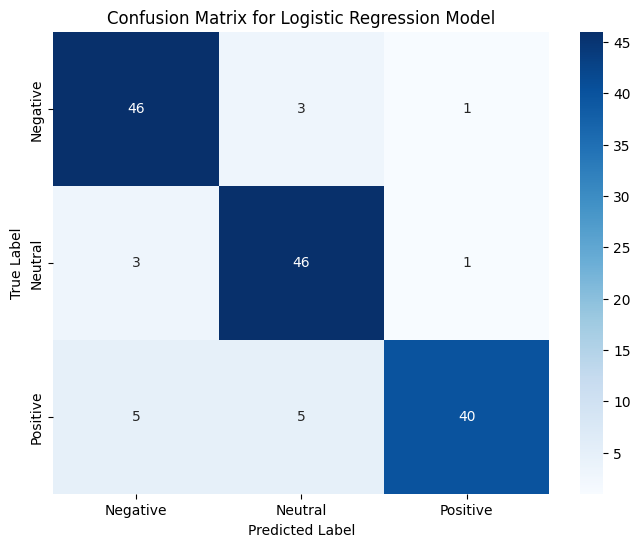


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

    Negative       0.85      0.92      0.88        50
     Neutral       0.85      0.92      0.88        50
    Positive       0.95      0.80      0.87        50

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



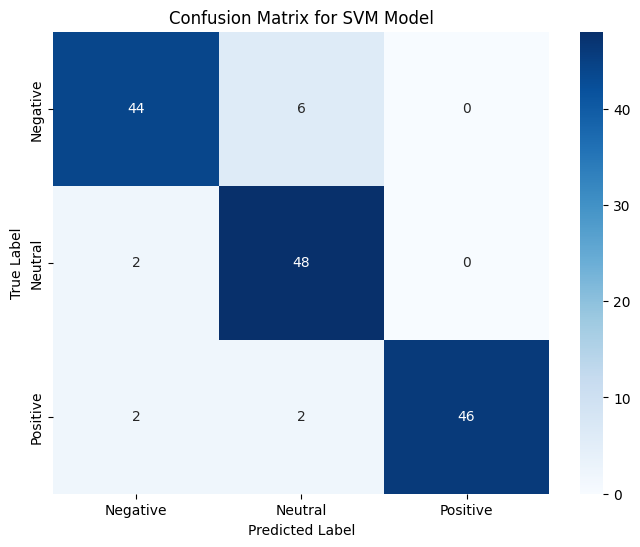


Classification Report for SVM:

              precision    recall  f1-score   support

    Negative       0.92      0.88      0.90        50
     Neutral       0.86      0.96      0.91        50
    Positive       1.00      0.92      0.96        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



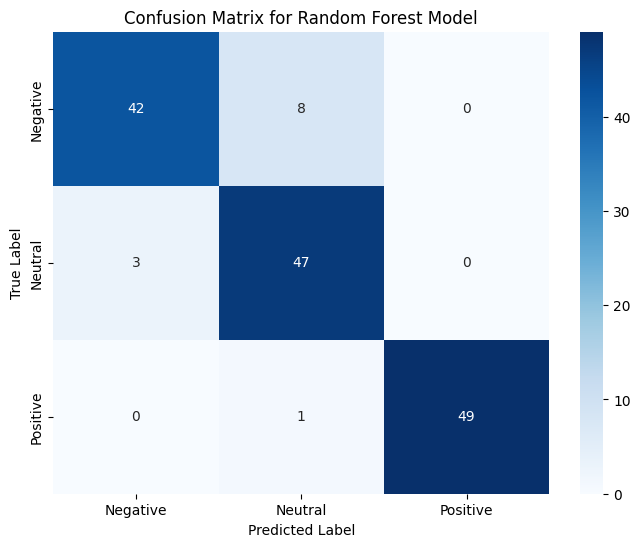


Classification Report for Random Forest:

              precision    recall  f1-score   support

    Negative       0.93      0.84      0.88        50
     Neutral       0.84      0.94      0.89        50
    Positive       1.00      0.98      0.99        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



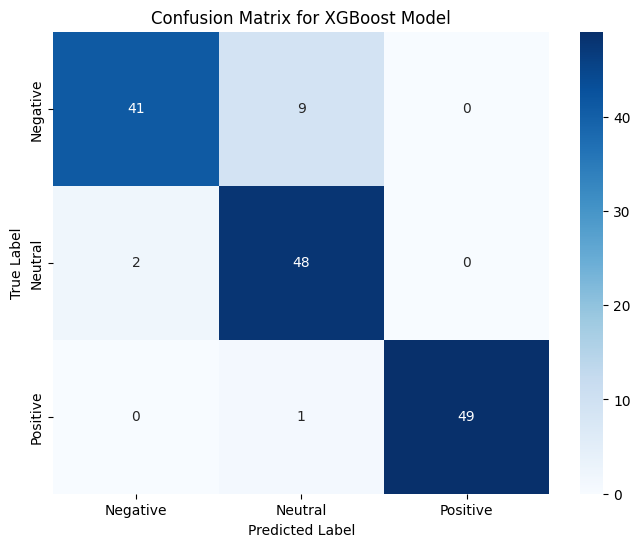


Classification Report for XGBoost:

              precision    recall  f1-score   support

    Negative       0.95      0.82      0.88        50
     Neutral       0.83      0.96      0.89        50
    Positive       1.00      0.98      0.99        50

    accuracy                           0.92       150
   macro avg       0.93      0.92      0.92       150
weighted avg       0.93      0.92      0.92       150



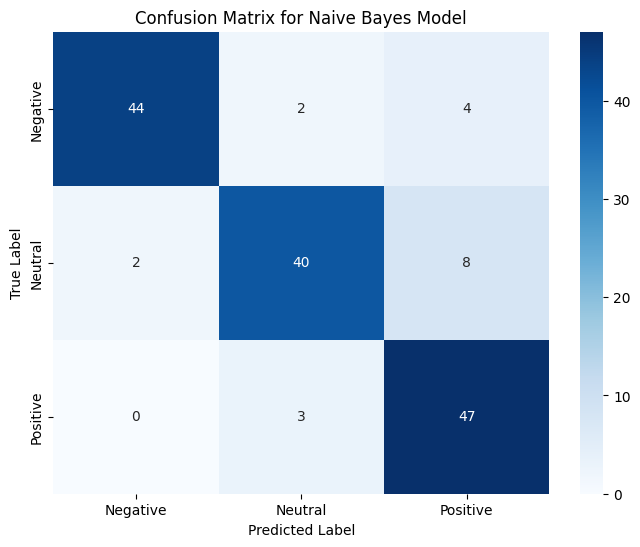


Classification Report for Naive Bayes:

              precision    recall  f1-score   support

    Negative       0.96      0.88      0.92        50
     Neutral       0.89      0.80      0.84        50
    Positive       0.80      0.94      0.86        50

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



In [34]:
for model_name, model in models.items():
    model.fit(X_train_combined, y_train)

    y_pred_test = model.predict(X_test_combined)

    cm = confusion_matrix(y_test, y_pred_test)
    class_names = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    filename = f'confusion_matrix_{model_name.replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred_test, target_names=class_names))